## Stable Diffusion XL1.0 fine tune with Lora in DreamBooth method
* This is an experiment for fine tune SD-XL-v1.0 with Kohya-ss unpublished sd-scripts.
* Character(Person) training example.
* SageMaker ml.g5.2xlarge notebook is fine to go(as sdxl needs more resources).
* Scripts and codes use [kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts).
* Training images come from [here](https://github.com/shirayu/example_lora_training).
* Lora training is basing on the method of DreamBooth+Caption(without using class_images to aviod over-fitting). 
* Besides the way of DreamBooth+Caption, Lora can also use other methods, such as DreamBooth+identifier+class and classic text2image fine tuning. Detailed info you can refer to https://github.com/darkstorm2150/sd-scripts/blob/main/docs/train_README-en.md
* If you can read Chinese and feel hard to dig info from kohya-ss repo, you can map the content from [Akegarasu repo](https://github.com/Akegarasu/lora-scripts) to kohya-ss for better understanding


# Fine tune model

## 1. Install dependencies

In [ ]:
!git clone -b sdxl https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!sed -i 's/diffusers\[torch\]==0\.18\.2/diffusers[torch]==0.19.3/g; s/tensorboard==2\.10\.1/tensorboard==2.11.0/g' requirements.txt
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install -U -r requirements.txt
!pip install xformers==0.0.20 wandb prodigyopt

In [2]:
# fix some warnings and bugs poping up from notebook

!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## 2. Initialize training environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
caption_extension = '.txt'
keep_tokens = 0

# DreamBooth caption based character datasets
[[datasets]]
resolution = 1024
# min_bucket_reso = 640
# max_bucket_reso = 1536
# bucket_reso_steps = 32
batch_size = 2

  [[datasets.subsets]]
  image_dir = './images/sample'
  num_repeats = 10

In [ ]:
%%writefile sample_prompts.txt
# prompt 1
wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2) --w 1024 --h 1024 --d 3129467234 --l 7.5 --s 20

# # prompt 2
wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2) --w 1024 --h 1024 --d 3129467235 --l 7.5 --s 20

In [6]:
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATASET_CONFIG = "./dataset.toml"
TRAIN_DATA_DIR = "./images/sample"
IMAGES_OUTPTS = "./images/outputs"
LORA_WEIGHT = "./lora_weight"
!mkdir -p $TRAIN_DATA_DIR $IMAGES_OUTPTS $LORA_WEIGHT

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/Wikipe-tan/* $TRAIN_DATA_DIR
!rm -rf dreambooth-stablediffusion-sagemaker-notebook

## 3. Train model

In [ ]:
!accelerate launch sdxl_train_network.py \
   --pretrained_model_name_or_path=$MODEL_NAME \
   --dataset_config=$DATASET_CONFIG \
   --output_dir=$LORA_WEIGHT \
   --network_module="networks.lora" \
   --max_train_epochs=10 \
   --network_train_unet_only \
   --learning_rate=1.0 \
   --lr_scheduler="cosine_with_restarts" \
   --lr_scheduler_num_cycles=1 \
   --network_dim=64 \
   --network_alpha=32 \
   --output_name="lora_wta" \
   --save_every_n_epochs=2 \
   --mixed_precision="fp16" \
   --gradient_checkpointing \
   --prior_loss_weight=1 \
   --max_token_length=225 \
   --save_model_as="safetensors" \
   --no_half_vae \
   --xformers \
   --optimizer_type="prodigy" \
   --sample_every_n_epochs=2 \
   --sample_prompts="./sample_prompts.txt" \
   --sample_sampler="euler_a" \
   --logging_dir="./logs" \
   --log_with="all" \
   --log_tracker_name="lora_wta" \
   --wandb_api_key="input your wandb api key"

## 4. Mode inference testing

In [ ]:
import torch
import datetime

from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

base_model = "stabilityai/stable-diffusion-xl-base-1.0"
refiner_model = base_model.replace('base', 'refiner')
lora_weight_name = "lora_wta.safetensors"

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(base_model, subfolder="scheduler")
generator = torch.Generator(device="cuda")
base_pipe = DiffusionPipeline.from_pretrained(base_model, scheduler=scheduler, torch_dtype=torch.float16, use_safetensors=True, variant="fp16").to("cuda")
base_pipe.load_lora_weights(LORA_WEIGHT, weight_name=lora_weight_name)
refiner_pipe = DiffusionPipeline.from_pretrained(refiner_model, text_encoder_2=base_pipe.text_encoder_2, vae=base_pipe.vae, torch_dtype=torch.float16, use_safetensors=True, variant="fp16").to("cuda")

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

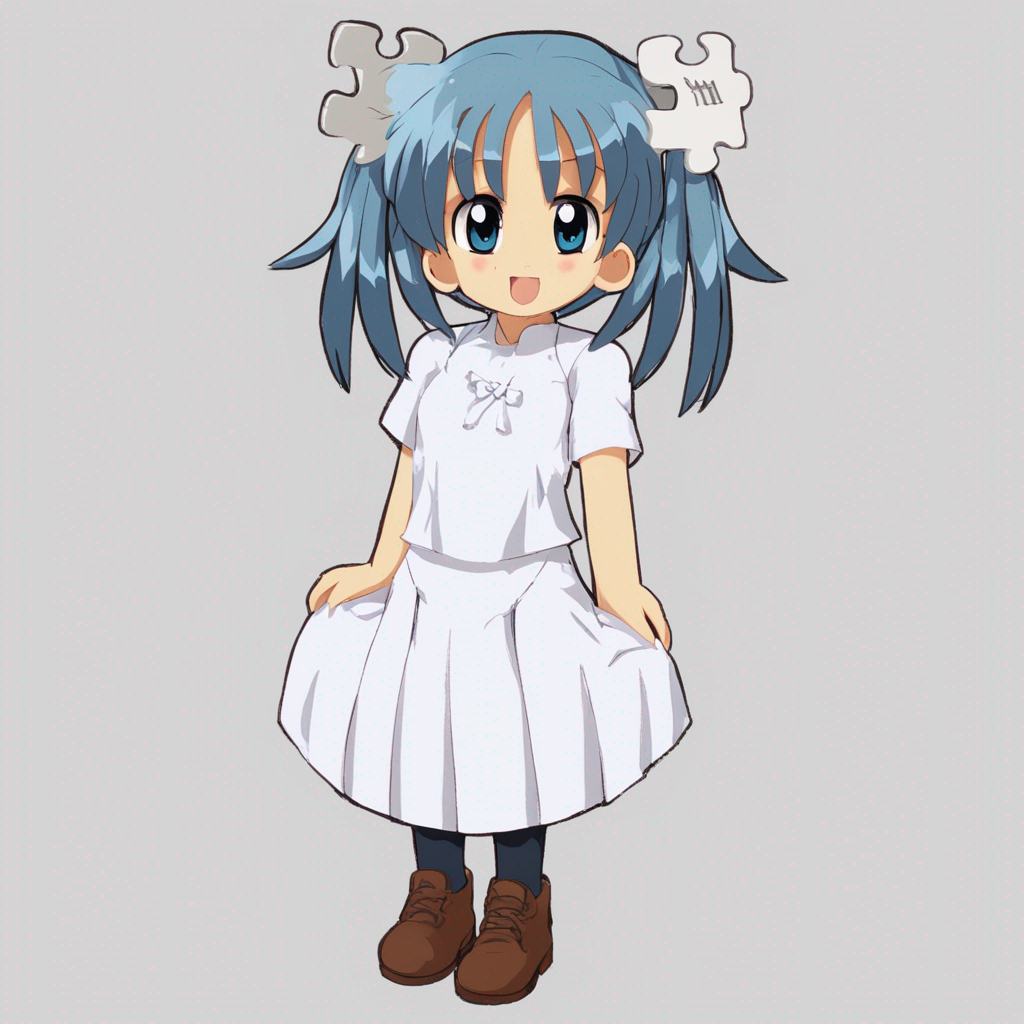

./images/outputs/5323037898866696_2023-08-09 17:31:44.png



  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

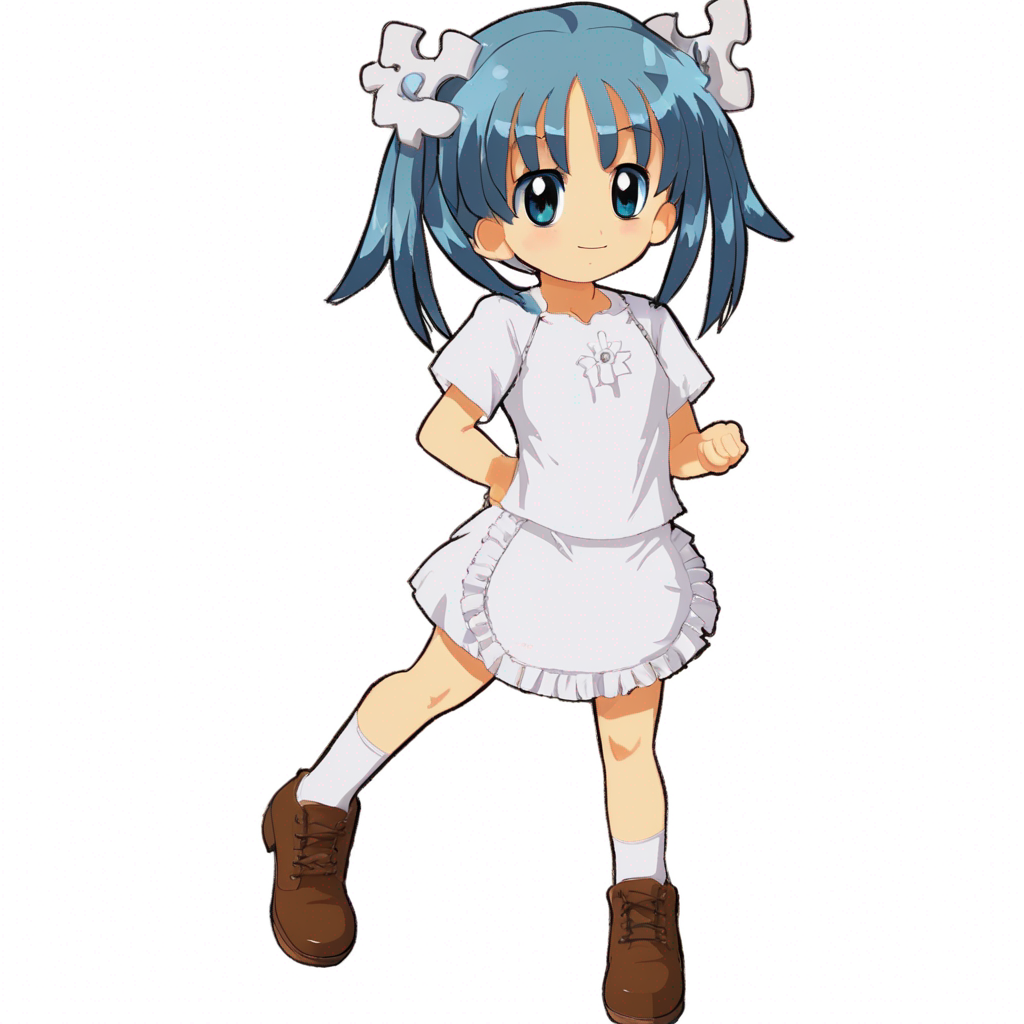

./images/outputs/6358156779529789_2023-08-09 17:31:54.png


Seeds for generating images: [5323037898866696, 6358156779529789]



In [25]:
prompt = "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo"
negative_prompt = "ugly, extra limbs, deformed legs, disfigured legs, mutated hands, misshapen hands, mutated fingers, fused fingers"

num_images = 2
seeds = []

for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image = base_pipe(
        prompt=prompt, 
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7,
        denoising_end=0.8,
        generator = generator,
        output_type="latent",
    ).images
    
    # Use refiner model
    image = refiner_pipe(
        prompt=prompt,
        num_inference_steps=20,
        denoising_start=0.8,
        image=image,
    ).images[0]
    
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)

# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

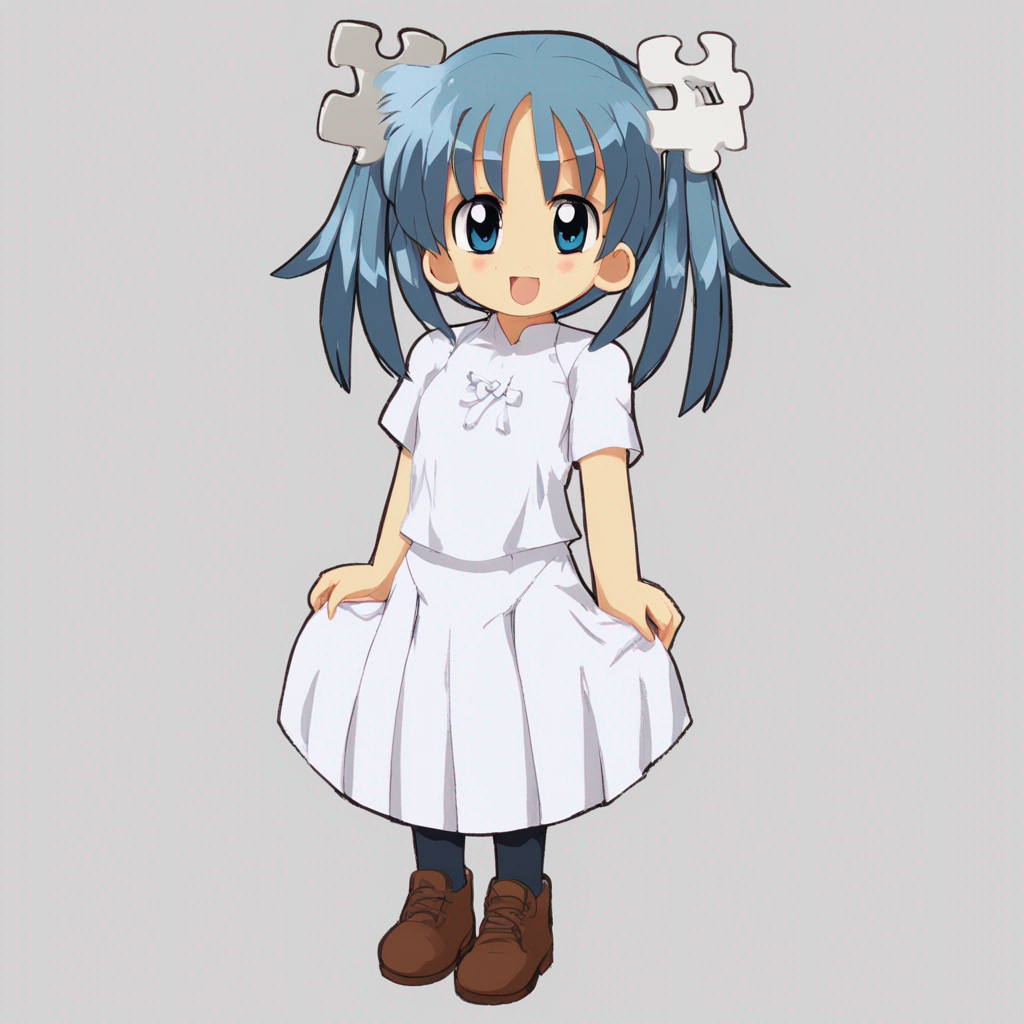

In [26]:
# Comment below codes, if you don't want to produce the same images again

seed = seeds[0] # use the first seed
generator.manual_seed(seed)

image = base_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    height=1024,
    width=1024,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7,
    denoising_end=0.8,
    generator = generator,
    output_type="latent",
).images
    
# Use refiner model
image = refiner_pipe(
    prompt=prompt,
    num_inference_steps=20,
    denoising_start=0.8,
    image=image,
).images[0]

display(image)

# Deploy model to SageMaker endpoint

## 1. Initialize SageMaker inference endpoint

In [14]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

## 2. Create "inference.py" script for SageMaker

In [15]:
!mkdir -p ./model/code

In [16]:
!cp ./lora_weight/lora_wta.safetensors ./model

In [ ]:
%%writefile ./model/code/requirements.txt
diffusers>=0.19.3
invisible_watermark
safetensors

In [ ]:
%%writefile ./model/code/inference.py
# Inference code example for sdxl-v1.0

import base64
import torch
from io import BytesIO
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

def model_fn(model_dir):
    base_model = "stabilityai/stable-diffusion-xl-base-1.0"
    refiner_model = base_model.replace('base', 'refiner')
    lora_weight_name = "lora_wta.safetensors"

    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(base_model, subfolder="scheduler")
    base_pipe = DiffusionPipeline.from_pretrained(
        base_model,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")
    base_pipe.load_lora_weights(model_dir, weight_name=lora_weight_name)
    refiner_pipe = DiffusionPipeline.from_pretrained(
        refiner_model,
        text_encoder_2=base_pipe.text_encoder_2,
        vae=base_pipe.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")

    return base_pipe, refiner_pipe


def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    return encoded_image_response


def predict_fn(data, base_and_refiner):
    generator = torch.Generator(device="cuda")
    use_refiner = data.pop("refiner", "")
    high_noise_frac = data.pop("high_noise_frac", 0.8)
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    height = data.pop("height", 1024)
    width = data.pop("width", 1024)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")

    seeds = []
    encoded_images = []

    if seed:
        seeds = [seed + i for i in range(num_images_per_prompt)]
    else:
        seeds = [generator.seed() for _ in range(num_images_per_prompt)]

    for current_seed in seeds:
        generator.manual_seed(current_seed)

        base_pipe, refiner_pipe = base_and_refiner

        if use_refiner == "enable":
            notification = "SDXL refiner model is enabled!"
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
            ).images
            generated_images = refiner_pipe(
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                denoising_start=high_noise_frac,
                image=generated_images,
            ).images[0]
        else:
            notification = "SDXL refiner model is disabled!"
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            ).images[0]

        encoded_image_rt = encode_image(generated_images)
        encoded_images.append(encoded_image_rt)

    return {"notification": notification, "generated_images": encoded_images, "seeds": seeds}

## 3. Package model and upload to S3 bucket

In [ ]:
!tar --use-compress-program=pigz -pcvf ./model/model.tar.gz -C ./model/ .

In [20]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path="./model/model.tar.gz", desired_s3_uri=f"s3://{sagemaker_session.default_bucket()}/model/sdxl-lora")

## 4. Deploy model by real-time inference endpoint

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.28.1",  # transformers version used
   pytorch_version="2.0.0",       # pytorch version used
   py_version='py310',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge"
    )

In [22]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


Notification: SDXL refiner model is enabled!



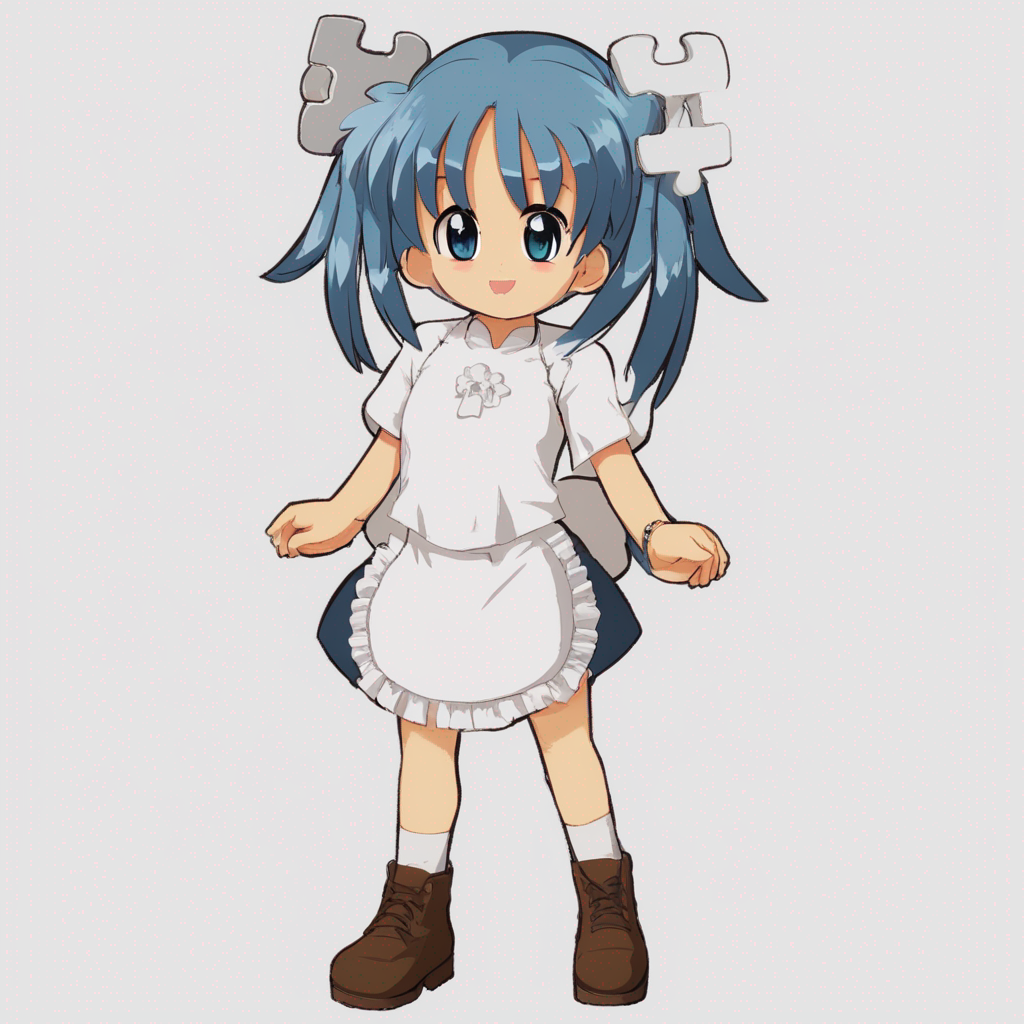

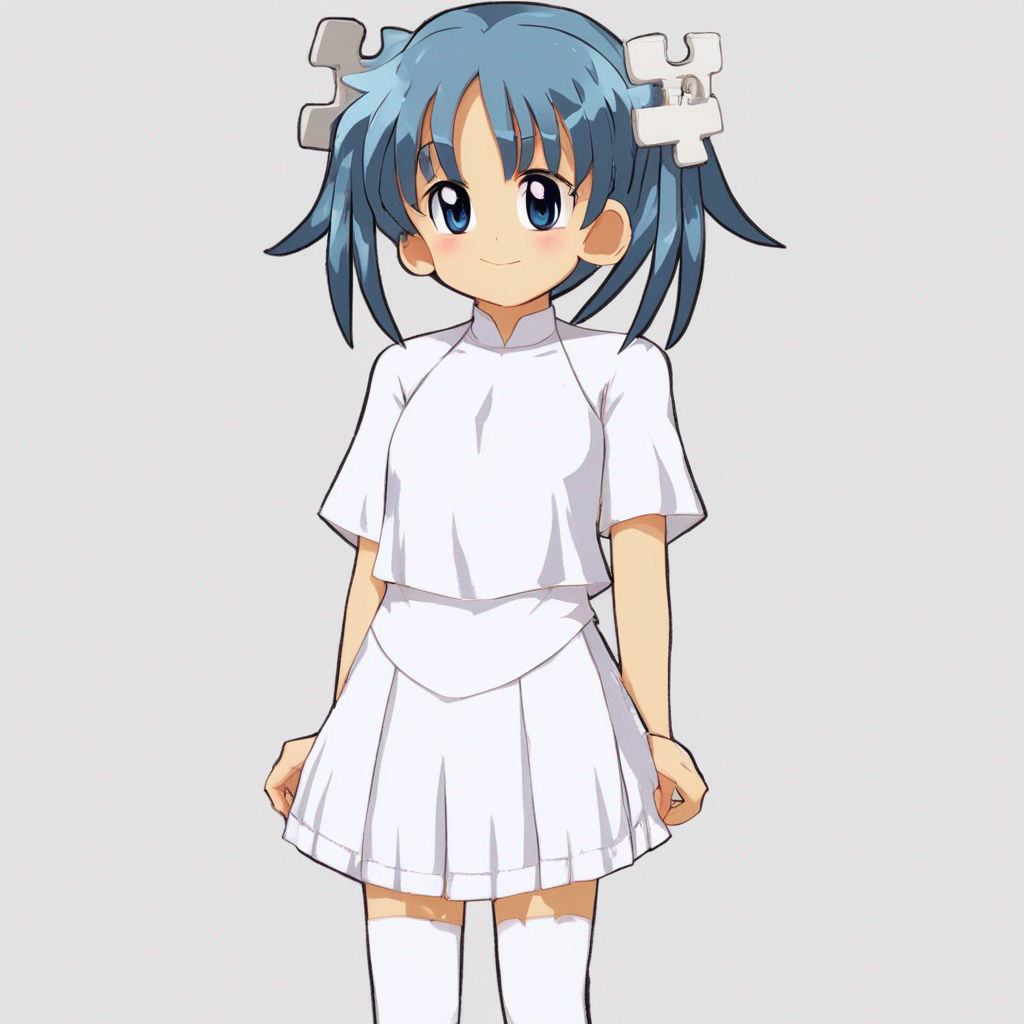


Seeds for generating images: [5097112425686906, 2705112439034260]


In [27]:
# run prediction
response = predictor.predict(data={
    "prompt": "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo, ultra quality, highly detailed",
    "negative_prompt": "extra limbs, deformed, disfigured, ugly, bad",
    "height": 1024,
    "width": 1024,
    "num_images_per_prompt": 2,
    "refiner": "enable",
    "high_noise_frac": 0.8,
    # "seed" : 860105273202351  # uncomment seed and replace with generated one, if you want to produce same
  }
)

print(f"\nNotification: {response['notification']}\n")

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")

## 5. Delete model and real-time endpoint 

In [ ]:
# uncomment below codes if you wanto to delete mode and endpoint for inference

# predictor.delete_model()
# predictor.delete_endpoint()